##### Copyright 2018 The TensorFlow Authors.

In [5]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classificação de intents

# Setup

In [6]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

import nltk

Importamos `matplotlib` e definimos funções ajudantes para plotar gráficos:

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Dataset
Lemos aqui o dataset utilizado, sendo composto de frases acompanhadas pelos intents definidos pelo grupo. Estes são "instruction", "definition", "explanation" e "comparison"

In [8]:
dataset = pd.read_csv('./dataset.csv', sep=';')
dataset.head()

,question,intent
0,Como usar lucros e reinvestir sem ser esmagado...,instruction
1,Como fazer boas escolhas de ações se 'resultad...,instruction
2,O que é Compra a Seco?,definition
3,Que eventos mais afetam os preços das ações?,explanation
4,Quais são os melhores recursos para aprender s...,instruction


Para eventual uso do One-Hot-Encoding, devemos traduzir os intents de strings para inteiros

In [9]:
intent_to_int = {
    'explanation': 0,
    'instruction': 1,
    'comparison': 2,
    'definition': 3
}
integer_intents = dataset['intent'].apply(lambda intent: intent_to_int[intent])
integer_intents.head()

0    1
1    1
2    3
3    0
4    1
Name: intent, dtype: int64

# Primeiros passos
Pré-processamento

Utilizaremos nltk para tokenizar as strings

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Antes de tokenizar, porém, é necessário que removamos caracteres supérfluos, como os de pontuação

In [11]:
forbidden_character_set = set(list('.?!;\','))
no_punctuation_strings = dataset['question'].apply(lambda sentence: ''.join(filter(lambda c: c not in forbidden_character_set, sentence)))
no_punctuation_strings.head()

0    Como usar lucros e reinvestir sem ser esmagado...
1    Como fazer boas escolhas de ações se resultado...
2                                O que é Compra a Seco
3          Que eventos mais afetam os preços das ações
4    Quais são os melhores recursos para aprender s...
Name: question, dtype: object

Resta, então, simplesmente chamar a função provida pelo nltk de tokenização de frases

In [12]:
tokenized_strings = no_punctuation_strings.apply(lambda sentence: word_tokenize(sentence.lower()))
tokenized_strings.head()

0    [como, usar, lucros, e, reinvestir, sem, ser, ...
1    [como, fazer, boas, escolhas, de, ações, se, r...
2                         [o, que, é, compra, a, seco]
3    [que, eventos, mais, afetam, os, preços, das, ...
4    [quais, são, os, melhores, recursos, para, apr...
Name: question, dtype: object

nltk também será utilizado para stemming

In [13]:
from nltk.stem import PorterStemmer
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [14]:
stemmer = nltk.stem.RSLPStemmer()

Mais uma vez, trata-se de mapear uma função sobre as entradas do dataset

In [15]:
stemmed_tokens = tokenized_strings.apply(lambda row: [stemmer.stem(word) for word in row])
stemmed_tokens.head()

0    [com, us, lucr, e, reinvest, sem, ser, esmag, ...
1    [com, faz, boa, escolh, de, açõ, se, result, p...
2                           [o, que, é, compr, a, sec]
3          [que, event, mais, afet, os, preç, da, açõ]
4    [qual, são, os, melhor, recurs, par, aprend, s...
Name: question, dtype: object

# One-Hot-Encoding
TensorFlow provê a função to_categorical, conveniente para o processo

In [16]:
ohe_intents = tf.keras.utils.to_categorical(integer_intents)
ohe_intents[:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [17]:
stringified_tokens = stemmed_tokens.apply(lambda tokens: ' '.join(tokens))
stringified_tokens.head()

0      com us lucr e reinvest sem ser esmag por impost
1    com faz boa escolh de açõ se result pass não s...
2                                  o que é compr a sec
3                   que event mais afet os preç da açõ
4    qual são os melhor recurs par aprend sobr inve...
Name: question, dtype: object

Em seguida, dividimos o dataset para treino e teste

In [18]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(stringified_tokens, ohe_intents, shuffle=True, random_state=random_state)

# Codificador de texto

Vamos utilizar as capacidades do TensorFlow para codificar as palavras

In [19]:
VOCAB = {word for words in stemmed_tokens for word in words}
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=len(VOCAB))
encoder.adapt(stringified_tokens.to_numpy())

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'o', 'que', 'de', 'invest', 'qual', 'é', 'são',
       'rend', 'fund', 'par', 'melhor', 'os', 'em', 'quant', 'por', 'a',
       'não', 'dinh'], dtype='<U10')

In [21]:
encoded_example = encoder(X_train)
encoded_example[:5]

<tf.Tensor: shape=(5, 28), dtype=int64, numpy=
array([[  6,   7,   2,  12,   5,  11,  30,  79, 101,  19,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,  12,  29,  60,  36,  40, 125,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  6,   8,  13,  12,  93,  11, 154,  82,   5,  14,  76,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2,   3,   7,  31,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,  53,  11,   4,  47,  23,  44,   4,   9,   5,  94, 166, 113,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Acima está um diagrama do modelo

1. Esse modelo pode ser cosntruído como um `tf.keras.Sequential`;
2. A primeira camada é o `codificador`, que converte o texto em uma sequência de índices de token;
3. Após o codificador está a camada de embedding. A camada de embedding guarda um vetor por palavra. Quando chamada, converte sequências de índices de palavras em sequência de vetores. Após treinamento (com dados o suficiente), palavras com significados semelhantes frequentemente têm vetores semelhantes.

Esta busca por índice é muito mais eficiente do que o processo equivalente de passar um vetor one-hot-encoded por uma camada `tf.keras.layers.Dense`.

4. Uma rede neural recorrente (RNN) processa input de sequências iterando pelos elementos. RNNs passam saídas de um passo temporal para entradas do próximo passo.

O _wrapper_ `tf.keras.layers.Bidirectional` também pode ser usado com uma camada RNN. Isto propaga a saída adiante e de volta através da camada RNN, e então concatena a saída final.

- A principal vantagem de uma RNN bidirecional é que o sinal do início da entrada não precisa ser processado totalmente através de cada passo temporal para afetar a saída;
- A principal desvantagem de uma RNN bidirecional é que não é possível transmitir predições, já que palavras são adicionadas ao fim.

5. Após a RNN ter convertido a sequência a um único vetor, as duas camadas `layers.Dense` fazer um processamento final, e convertem dessa representação vetorial para um único logit como saída de classificação

Este é o código da implementação:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

Perceba que o modelo sequencial do Keras é utilizado aqui, já que todas as camadas no modelo tem uma única entrada e produzem uma única saída correspondente. No caso de ser desejada uma camada RNN _stateful_, pode-se querer construir o modelo com a API funcional do Keras ou _model subclassing_, para recuperar e reutilizar os estados das camadas RNN. Para mais detalhes, ver [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

A camada de embedding [usa _masking_](https://www.tensorflow.org/guide/keras/masking_and_padding) para lidar com sequências de tamanhos diferentes. Todas as camadas após `Embedding` suportam _masking_:

In [23]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


Para confirmar que isto funciona como esperado, avaliar-se-á uma sentença duas vezes. Primeiramente, sozinha, para que não haja _padding_ em que se usar _mask_:

In [24]:
sample_text = ('Quero ficar rico')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.50205743 0.49737495 0.5003961  0.5010144 ]


Agora, avaliar-se-á novamente em um lote com uma sentença mais longa. O resultado deve ser idêntico:

In [25]:
padding = "O " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.50205743 0.49737495 0.5003961  0.5010144 ]


Compila-se o modelo Keras para configurar o processo de treinamento:

In [26]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Treinando o modelo

In [27]:
history = model.fit(X_train, y_train, epochs=160,
                    validation_data=(X_test, y_test))

Epoch 1/160
2/2 [==============================] - 9s 2s/step - loss: 1.3853 - accuracy: 0.3212 - val_loss: 1.3855 - val_accuracy: 0.3333
Epoch 2/160
2/2 [==============================] - 0s 143ms/step - loss: 1.3837 - accuracy: 0.3990 - val_loss: 1.3845 - val_accuracy: 0.4000
Epoch 3/160
2/2 [==============================] - 0s 134ms/step - loss: 1.3823 - accuracy: 0.4300 - val_loss: 1.3835 - val_accuracy: 0.4667
Epoch 4/160
2/2 [==============================] - 0s 209ms/step - loss: 1.3813 - accuracy: 0.4455 - val_loss: 1.3825 - val_accuracy: 0.4667
Epoch 5/160
2/2 [==============================] - 0s 187ms/step - loss: 1.3798 - accuracy: 0.5128 - val_loss: 1.3816 - val_accuracy: 0.4667
Epoch 6/160
2/2 [==============================] - 0s 291ms/step - loss: 1.3782 - accuracy: 0.5441 - val_loss: 1.3807 - val_accuracy: 0.4667
Epoch 7/160
2/2 [==============================] - 0s 214ms/step - loss: 1.3771 - accuracy: 0.5337 - val_loss: 1.3798 - val_accuracy: 0.5333
Epoch 8/160
2/2 

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 72ms/step - loss: 1.0877 - accuracy: 0.6000
Test Loss: 1.0877286195755005
Test Accuracy: 0.6000000238418579


(0.0, 1.4407826200127603)

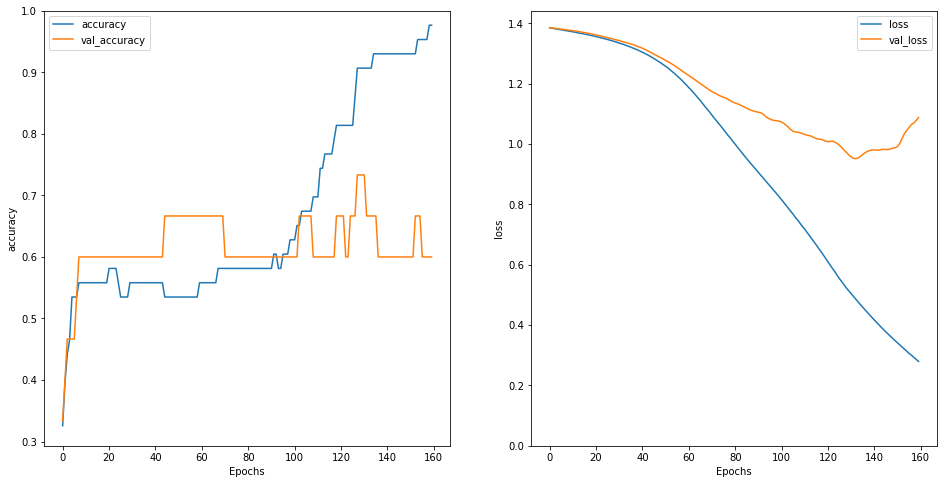

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Pode-se avaliar uma sentença agora:

In [33]:
sample_text = ('Pode me dizer o que é fundo de investimento?')
predictions = model.predict(np.array([sample_text]))
int_to_intent = { val : key for key, val in intent_to_int.items() }
int_to_intent[np.argmax(predictions[0])]

'definition'